## Marginal Likelihood Implementation

So far we have looked at **prior** Gaussian processes (GPP), without the incorporation of information encoded in data. Having expressed a GPP, we want to update this prior information with our data, via Bayes' formula:

<div style="font-size: 150%;">
$$
Pr(\theta | y) \propto Pr(y | \theta) Pr(\theta)
$$
</div>
<br>

For example, we may wish to solve a non-linear regression function:

<div style="font-size: 150%;">
$$
\begin{aligned}
  \mathbf{y} &= f(X) + \mathbf{\epsilon} \\
  \mathbf{\epsilon} &\sim N(0, \Sigma)
\end{aligned}
$$
</div>
<br>

The `gp.Marginal` class in PyMC3 implements the simplest case of GP regression:  **the observed data are the sum of a GP and Gaussian noise**.  `gp.Marginal` has a `marginal_likelihood` method, a `conditional` method, and a `predict` method.  Given a mean and covariance function, the function $f(x)$ is modeled as:

<div style="font-size: 150%;">
$$
f(x) \sim \mathcal{GP}(m(x),\, k(x, x')) \,.
$$
</div>
<br>

### The Marginal Likelihood

Recall from the introduction that the presence of an intractible normalizing constant $Pr(y)$ makes the direct calculation of the posterior distribution infeasible:

<div style="font-size: 150%;">  
\\[Pr(\theta|y) = \frac{Pr(y|\theta)Pr(\theta)}{Pr(y)}\\]
</div>
<br>

The marginal likelihood is the normalizing constant for the posterior distribution, and is the integral of the product of the likelihood and prior.

<div style="font-size: 150%;">  
$$p(y) = \int_f p(y|f)p(f) df$$
</div>
<br>

where for Gaussian processes, we are marginalizing over function values $f$ (instead of parameters $\theta$).

**GP prior**:

$$\log p(f|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K| -\frac{1}{2}f^TK^{-1}f $$

**Gaussian likelihood**:

$$\log p(y|f,X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|\sigma^2I| -\frac{1}{2}(y-f)^T(\sigma^2I)^{-1}(y-f) $$

**Marginal likelihood**:

$$\log p(y|X) = - \frac{k}{2}\log2\pi - \frac{1}{2}\log|K + \sigma^2I| - \frac{1}{2}y^T(K+\sigma^2I)^{-1}y $$

Notice that the marginal likelihood includes both a data fit term $- \frac{1}{2}y^T(K+\sigma^2I)^{-1}y$ and a parameter penalty term $\frac{1}{2}\log|K + \sigma^2I|$. Hence, the marginal likelihood can help us select an appropriate covariance function, based on its fit to the dataset at hand.

### Choosing parameters

This is relevant because we have to make choices regarding the parameters of our Gaussian process; they were chosen arbitrarily for the random functions we demonstrated above.

For example, in the squared exponential covariance function, we must choose two parameters:

$$k(x,x^{\prime}) = \theta_1\exp\left(-\frac{\theta_2}{2}(x-x^{\prime})^2\right)$$

The first parameter $\theta_1$ is a scale parameter, which allows the function to yield values outside of the unit interval. The second parameter $\theta_2$ is a length scale parameter that determines the degree of covariance between $x$ and $x^{\prime}$; smaller values will tend to smooth the function relative to larger values.

We can use the **marginal likelihood** to select appropriate values for these parameters, since it trades off model fit with model complexity. Thus, an optimization procedure can be used to select values for $\theta$ that maximize the marginial likelihood.

Now that we have a general idea about covariance functions, let's begin by defining one for our first model.

The following simulated data clearly shows some type of non-linear process, corrupted by a certain amount of observation or measurement error so it should be a reasonable task for a Gaussian process approach.

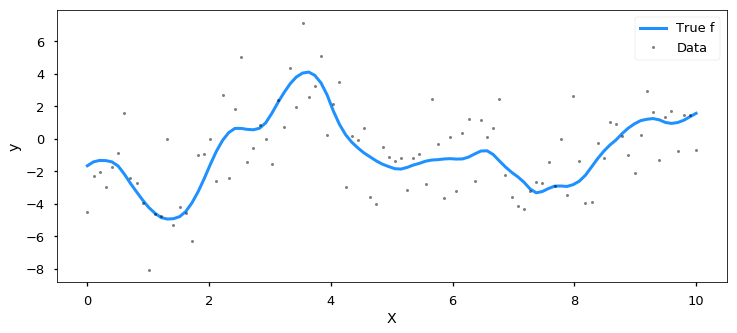

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import matplotlib.cm as cmap
import seaborn as sns
sns.set_context('talk')

# set the seed
np.random.seed(42)

n = 100 # The number of data points
x = np.linspace(0, 10, n)
X = x[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(1, ℓ_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(), 
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of IID Gaussian noise
# The standard deviation of the noise is `sigma`
σ_true = 2.0
y = f_true + σ_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, alpha=0.5, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

We can use a Matern(5/2) covariance to model our simulated data, and pass this as the `cov_func` argument to the `Marginal` class.

In [2]:
with pm.Model() as model:
    
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    
    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)
    mean = pm.gp.mean.Constant(c=1)
    gp = pm.gp.Marginal(mean_func=mean, cov_func=cov)

### The `.marginal_likelihood` method

The unknown latent function can be analytically integrated out of the product of the GP prior probability with a normal likelihood.  This quantity is called the marginal likelihood. 

$$
p(y \mid x) = \int p(y \mid f, x) \, p(f \mid x) \, df
$$

The log of the marginal likelihood, $p(y \mid x)$, is

$$
\log p(y \mid x) = 
  -\frac{1}{2} (\mathbf{y} - \mathbf{m}_x)^{T} 
               (\mathbf{K}_{xx} + \boldsymbol\Sigma)^{-1} 
               (\mathbf{y} - \mathbf{m}_x)
  - \frac{1}{2}|\mathbf{K}_{xx} + \boldsymbol\Sigma|
  - \frac{n}{2}\log (2 \pi)
$$

$\boldsymbol\Sigma$ is the covariance matrix of the Gaussian noise.  Since the Gaussian noise doesn't need to be white to be conjugate, the `marginal_likelihood` method supports either using a white noise term when a scalar is provided, or a noise covariance function when a covariance function is provided.

The `gp.marginal_likelihood` method implements the quantity given above.

In [3]:
x = np.linspace(0, 10, 100)
X = x.reshape(-1, 1)

with model:
    
    σ = pm.HalfCauchy("σ", beta=5)
    obs = gp.marginal_likelihood("obs", X=X, y=y, noise=σ)

In [4]:
with model:
    marginal_post = pm.find_MAP()

logp = -231.06, ||grad|| = 0.033576: 100%|██████████| 15/15 [00:00<00:00, 270.78it/s]


We can collect the results into a pandas dataframe to display

In [5]:
import pandas as pd 

pd.DataFrame({"Parameter": ["ℓ", "η", "σ"], 
              "Value at MAP": [float(marginal_post["ℓ"]), float(marginal_post["η"]), float(marginal_post["σ"])],
              "True value": [ℓ_true, η_true, σ_true]})

,Parameter,True value,Value at MAP
0,ℓ,1.0,0.900896
1,η,3.0,2.362488
2,σ,2.0,1.991166


### The `.conditional` distribution

In addition to fitting the model, we would like to be able to generate predictions. This implies sampling from the posterior predictive distribution, which if you recall is just some linear algebra:

$$
f(y^* | y, x, x^*) \sim \mathcal{GP}(m^*(x^*),\, k^*(x^*)) \,
$$

where

$$\begin{aligned}
m^*(x^*) &= k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}y \\
k^*(x^*) &= k(x^*,x^*)+\sigma^2 - k(x^*,x)^T[k(x,x) + \sigma^2I]^{-1}k(x^*,x)
\end{aligned}$$

PyMC3 allows for predictive sampling after the model is fit, using the recorded values of the model parameters to generate samples. The `conditional` method implements the predictive GP above, called with a grid of points over which to generate realizations:

The `.conditional` has an optional flag for `pred_noise`, which defaults to `False`.  When `pred_noise=False`, the `conditional` method produces the predictive distribution for the underlying function represented by the GP.  When `pred_noise=True`, the `conditional` method produces the predictive distribution for the GP plus noise.  

If using an additive GP model, the conditional distribution for individual components can be constructed by setting the optional argument `given`.  

We can define a grid of new values from `x=0` to `x=20`, then add the GP conditional to the model, given the new X values:



In [9]:
X_new = np.linspace(0, 20, 600)[:,None]

with model:
    f_pred = gp.conditional("f_pred", X_new)

We can draw samples from the posterior predictive distribution over the specified grid of values.

In [10]:
with model:
    pred_samples = pm.sample_ppc([marginal_post], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [01:01<00:00, 32.27it/s]


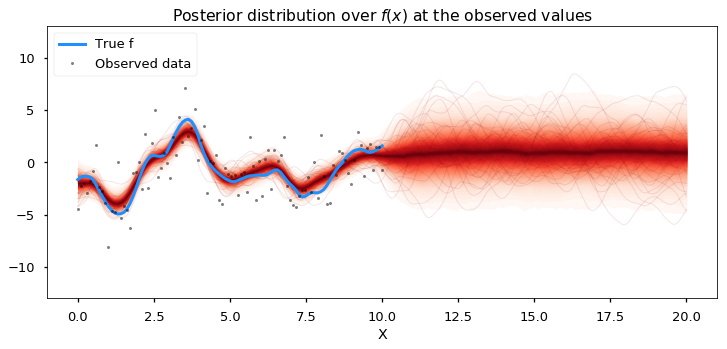

In [11]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X_new);

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-13,13]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

The prediction also matches the results from `gp.Latent` very closely.  What about predicting new data points?  Here we only predicted $f_*$, not $f_*$ + noise, which is what we actually observe.

The `conditional` method of `gp.Marginal` contains the flag `pred_noise` whose default value is `False`.  To draw from the *posterior predictive* distribution, we simply set this flag to `True`. 

In [12]:
with model:
    y_pred = gp.conditional("y_pred", X_new, pred_noise=True)
    y_samples = pm.sample_ppc([marginal_post], vars=[y_pred], samples=2000)

100%|██████████| 2000/2000 [01:57<00:00, 17.09it/s]


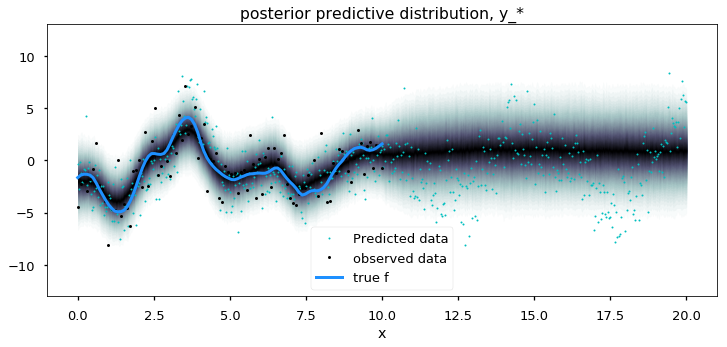

In [13]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# posterior predictive distribution
plot_gp_dist(ax, y_samples["y_pred"], X_new, plot_samples=False, palette="bone_r");

# overlay a scatter of one draw of random points from the 
#   posterior predictive distribution
plt.plot(X_new, y_samples["y_pred"][800, :].T, "co", ms=2, label="Predicted data");

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("posterior predictive distribution, y_*"); plt.legend();

### Real-world example: Spawning salmon

That was contrived data; let's try applying Gaussian processes to a real problem. The plot below shows the relationship between the number of spawning salmon in a particular stream and the number of fry that are recruited into the population in the spring.

We would like to model this relationship, which appears to be non-linear (we have biological knowledge that suggests it should be non-linear too).

![](images/spawn.jpg)

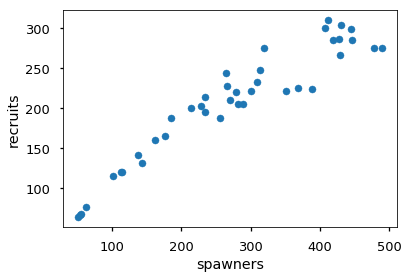

In [14]:
salmon_data = pd.read_table('data/salmon.txt', sep='\s+', index_col=0)
salmon_data.plot.scatter(x='spawners', y='recruits', s=50);

In [15]:
with pm.Model() as salmon_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 1)
    η = pm.HalfCauchy('η', 1)
    
    M = pm.gp.mean.Linear(coeffs=(salmon_data.recruits/salmon_data.spawners).mean())
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfCauchy('σ', 1)
    
    recruit_gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    recruit_gp.marginal_likelihood('recruits', X=salmon_data.spawners.values.reshape(-1,1), 
                           y=salmon_data.recruits.values, noise=σ)
    

In [16]:
with salmon_model:
    salmon_trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 1500/1500 [00:29<00:00, 51.27it/s]


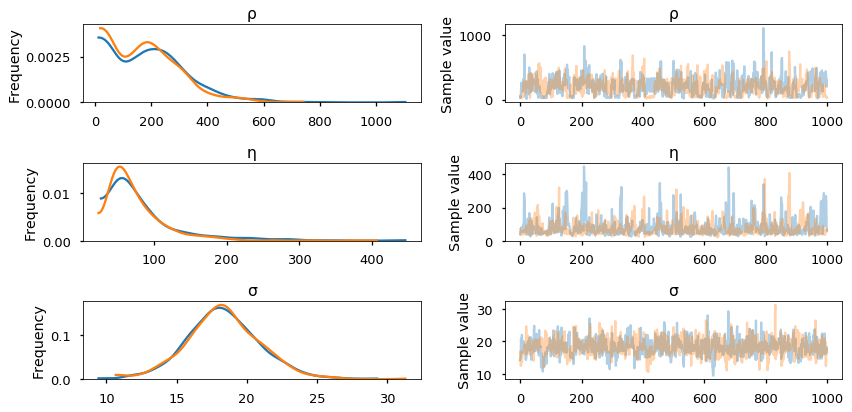

In [17]:
pm.traceplot(salmon_trace, varnames=['ρ', 'η', 'σ']);

In [18]:
X_pred = np.linspace(0, 500, 100).reshape(-1, 1)
with salmon_model:
    salmon_pred = recruit_gp.conditional("salmon_pred", X_pred)
    salmon_samples = pm.sample_ppc(salmon_trace, vars=[salmon_pred], samples=3)

100%|██████████| 3/3 [00:00<00:00,  3.01it/s]


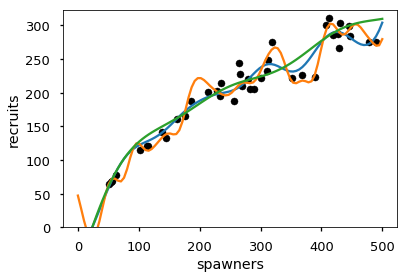

In [19]:
ax = salmon_data.plot.scatter(x='spawners', y='recruits', c='k', s=50)
ax.set_ylim(0, None)
for x in salmon_samples['salmon_pred']:
    ax.plot(X_pred, x);

### Exercise

We might be interested in what may happen if the population gets very large -- say, 600 or 800 spawners. We can predict this, though it goes well outside the range of data that we have observed. Generate predictions from the posterior predictive distribution (via `conditional`) that covers this range of spawners.

In [20]:
# Write answer here

### Using `.predict`

We can use the `.predict` method to return the mean and variance given a particular `point`.  Since we used `find_MAP` in this example, `predict` returns the same mean and covariance that the distribution of `.conditional` has.  

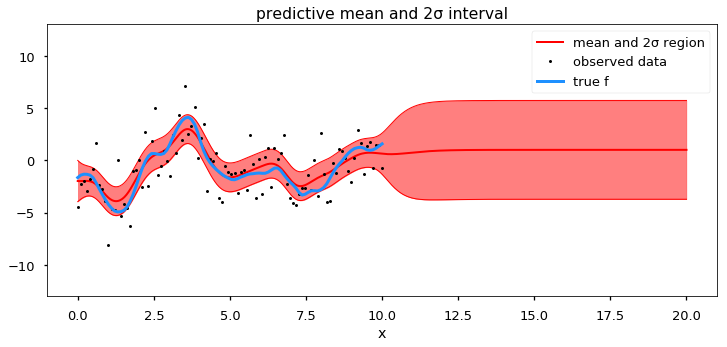

In [21]:
# predict
mu, var = gp.predict(X_new, point=marginal_post, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(X_new, mu + 2*sd, 'r', lw=1); plt.plot(X_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data");
plt.plot(X, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x"); plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();